<a href="https://colab.research.google.com/github/SeeBook2022/SeeBook-OCR/blob/model_design/stage1_to_3_combine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 환경설정

In [ ]:
import re
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
%matplotlib inline

In [ ]:
!git clone https://github.caom/ultralytics/yolov5

fatal: destination path 'yolov5' already exists and is not an empty directory.


In [ ]:
!cd yolov5; pip install -qr requirements.txt

In [ ]:
!pip install --upgrade google-api-python-client

In [ ]:
!pip install google-cloud-vision

In [ ]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = '/content/drive/MyDrive/Aiffel_Hakathon/my_google_api_key.json'

In [ ]:
def file_sorted(files):
    temp = [re.split(r"([0-9]+)", s) for s in files]
    sort = sorted(temp, key = lambda x: (x[0].lower(), int(x[1])))
    
    return [''.join(s) for s in sort]

In [ ]:
def make_file_paths(path):
    img_names = os.listdir(path)
    file_names = file_sorted(img_names)
    file_paths = []
    for file_name in file_names:
        file_paths.append(path + file_name)

    return file_paths

In [ ]:
def make_imglist(dir_path):
    img_list = []
    file_paths = make_file_paths(dir_path)
    for file_path in file_paths:
        img_array = cv2.imread(file_path)[...,::-1]
        img_list.append(img_array)

    return img_list

### stage1. bookspine detection

In [ ]:
start = time.time()

stage1_model = torch.hub.load('ultralytics/yolov5', 'custom', path='/content/drive/MyDrive/Aiffel_Hakathon/3rd_hackathon/model_test_ver2/stage1/stage1_weights/stage1_m_epochs_50.pt')

stage1_model.conf = 0.3
# result_list = []

img_path = '/content/drive/MyDrive/Aiffel_Hakathon/3rd_hackathon/model_combine/stage1_test_image/test6.jpg'
img = cv2.imread(img_path)[..., ::-1]

results = stage1_model(img)
stage1_df = results.pandas().xyxy[0]
print(str(time.time() - start) +' sec')   

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-3-1 torch 1.10.0+cu111 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model Summary: 290 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 


0.9679205417633057 sec


In [ ]:
stage1_df

,xmin,ymin,xmax,ymax,confidence,class,name
0,917.396484,299.811584,1188.054199,2786.784180,0.915327,0,book
1,2249.994385,278.371521,2494.057373,2821.194092,0.910894,0,book
2,587.161621,287.250031,886.554626,2793.372070,0.909943,0,book
3,1445.635498,0.000000,1679.305664,2884.898193,0.905176,0,book
4,1963.661499,153.834259,2238.204102,2842.036621,0.902216,0,book
5,31.729342,130.973969,285.928162,2811.021973,0.901761,0,book
6,2756.038086,56.115524,3001.585449,2835.105713,0.901092,0,book
7,3529.113037,79.285637,3821.340820,2852.772705,0.896637,0,book
8,1735.231201,273.729187,1945.319092,2814.708740,0.892430,0,book
9,339.365570,291.282715,569.484436,2796.272949,0.888372,0,book


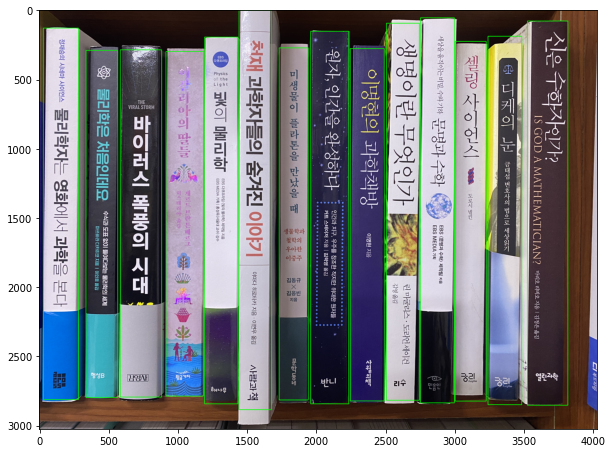

In [ ]:
img_file_path = '/content/drive/MyDrive/Aiffel_Hakathon/3rd_hackathon/model_combine/stage1_test_image/test6.jpg'
img = cv2.imread(img_file_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
green = (0, 255, 0)

for i in range(stage1_df.shape[0]):
    bbox = stage1_df.iloc[i][:4].tolist()
    img_show = cv2.rectangle(img_rgb, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), color = green, thickness = 4) # label_bbox 표시 
plt.figure(figsize=(10,10))
plt.imshow(img_rgb)
plt.show()

### stage1.5 choose bbox

In [ ]:
# ex. 0~3번 index의 bbox 선택을 가정
stage1_bbox_list = []

for i in range(4):
    stage1_bbox_list.append(stage1_df.iloc[i][:4].tolist())

stage1_bbox_list

[[917.396484375, 299.81158447265625, 1188.05419921875, 2786.7841796875],
 [2249.994384765625, 278.37152099609375, 2494.057373046875, 2821.194091796875],
 [587.16162109375, 287.2500305175781, 886.5546264648438, 2793.3720703125],
 [1445.635498046875, 0.0, 1679.3056640625, 2884.898193359375]]

### stage1.5 crop image

In [ ]:
stage1_to_stage2 = []

for bbox_coord in stage1_bbox_list:
    img_crop = img[int(bbox_coord[1]):int(bbox_coord[3]), int(bbox_coord[0]):int(bbox_coord[2])].copy()
    stage1_to_stage2.append(img_crop)

stage1_to_stage2

[array([[[  7,   4,  13],
         [  8,   5,  14],
         [  7,   4,  13],
         ...,
         [186, 170, 188],
         [182, 167, 188],
         [187, 172, 193]],
 
        [[  5,   2,  11],
         [  7,   4,  13],
         [ 11,   8,  17],
         ...,
         [182, 166, 184],
         [182, 167, 188],
         [186, 171, 192]],
 
        [[  5,   2,  11],
         [  7,   4,  13],
         [ 13,  10,  19],
         ...,
         [182, 166, 184],
         [184, 169, 190],
         [183, 168, 189]],
 
        ...,
 
        [[ 41,  48,  63],
         [ 43,  49,  62],
         [ 44,  47,  61],
         ...,
         [ 74,  74,  90],
         [ 72,  73,  87],
         [ 66,  66,  78]],
 
        [[ 47,  57,  74],
         [ 37,  47,  65],
         [ 37,  44,  63],
         ...,
         [ 77,  84, 101],
         [ 75,  78,  93],
         [ 60,  60,  72]],
 
        [[ 51,  63,  81],
         [ 45,  56,  76],
         [ 43,  54,  74],
         ...,
         [ 86,  93, 112],
  

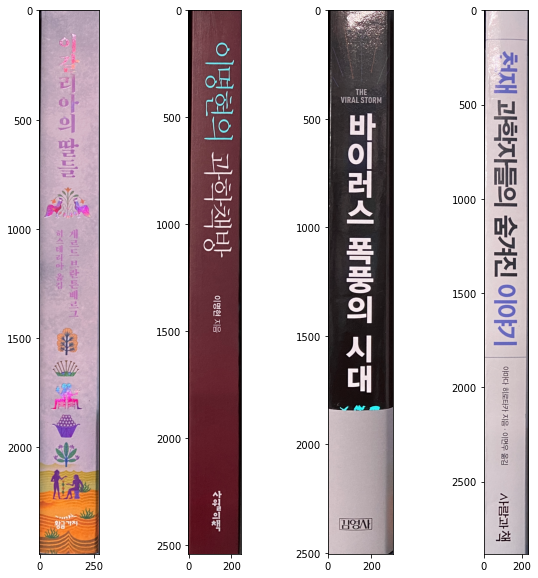

In [ ]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(1,4,1)
ax2 = fig.add_subplot(1,4,2)
ax3 = fig.add_subplot(1,4,3)
ax4 = fig.add_subplot(1,4,4)
ax1.imshow(stage1_to_stage2[0])
ax2.imshow(stage1_to_stage2[1])
ax3.imshow(stage1_to_stage2[2])
ax4.imshow(stage1_to_stage2[3])
fig.show()


### stage2. booktitle detection

In [ ]:
start = time.time()

stage2_model = torch.hub.load('ultralytics/yolov5', 'custom', path='/content/drive/MyDrive/Aiffel_Hakathon/3rd_hackathon/stage2_iou_test/stage2_final.pt')

stage2_model.max_det = 1
stage2_model.conf = 0.3
stage2_result = []

for i, img in enumerate(stage1_to_stage2):
    results = stage2_model(img)
    make_list = results.pandas().xyxy[0].iloc[0].tolist()
    stage2_result.append(make_list)
print(str(time.time() - start) +' sec')   

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-3-1 torch 1.10.0+cu111 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model Summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


0.8001375198364258 sec


In [ ]:
stage2_result

[[61.58040237426758,
  87.12255859375,
  200.67352294921875,
  807.287353515625,
  0.7408238053321838,
  0,
  'title'],
 [52.32343673706055,
  109.39945983886719,
  229.1051483154297,
  1179.8291015625,
  0.8821976184844971,
  0,
  'title'],
 [62.29026412963867,
  451.5108947753906,
  220.50660705566406,
  1014.176513671875,
  0.750309407711029,
  0,
  'title'],
 [22.1203556060791,
  248.4451904296875,
  201.65052795410156,
  1805.8128662109375,
  0.8342416286468506,
  0,
  'title']]

In [ ]:
# stage2의 bbox를 리스트로 출력

stage2_bbox_list = []
for i, coord in enumerate(stage2_result):
    stage2_bbox_list.append(stage2_result[i][:4])

stage2_bbox_list

[[61.58040237426758, 87.12255859375, 200.67352294921875, 807.287353515625],
 [52.32343673706055, 109.39945983886719, 229.1051483154297, 1179.8291015625],
 [62.29026412963867, 451.5108947753906, 220.50660705566406, 1014.176513671875],
 [22.1203556060791, 248.4451904296875, 201.65052795410156, 1805.8128662109375]]

In [ ]:
stage2_2_stage3 = []
stage2_img = ''
for i, stage1_crop in enumerate(stage1_to_stage2):
    stage2_img_crop = stage1_crop[int(stage2_bbox_list[i][1]):int(stage2_bbox_list[i][3]), int(stage2_bbox_list[i][0]):int(stage2_bbox_list[i][2])].copy()
    stage2_2_stage3.append(stage2_img_crop)

stage2_2_stage3

[array([[[177, 158, 177],
         [177, 158, 177],
         [179, 160, 179],
         ...,
         [182, 162, 181],
         [182, 162, 181],
         [185, 165, 184]],
 
        [[182, 163, 182],
         [175, 156, 175],
         [172, 153, 172],
         ...,
         [185, 165, 184],
         [184, 164, 183],
         [185, 165, 184]],
 
        [[183, 164, 183],
         [174, 155, 174],
         [170, 151, 170],
         ...,
         [186, 166, 185],
         [186, 166, 185],
         [187, 167, 186]],
 
        ...,
 
        [[194, 168, 186],
         [195, 169, 187],
         [199, 173, 191],
         ...,
         [207, 180, 196],
         [202, 175, 191],
         [200, 173, 189]],
 
        [[193, 167, 185],
         [193, 167, 185],
         [195, 169, 187],
         ...,
         [212, 183, 199],
         [209, 180, 196],
         [205, 176, 192]],
 
        [[195, 169, 187],
         [192, 166, 184],
         [190, 164, 182],
         ...,
         [211, 182, 198],
  

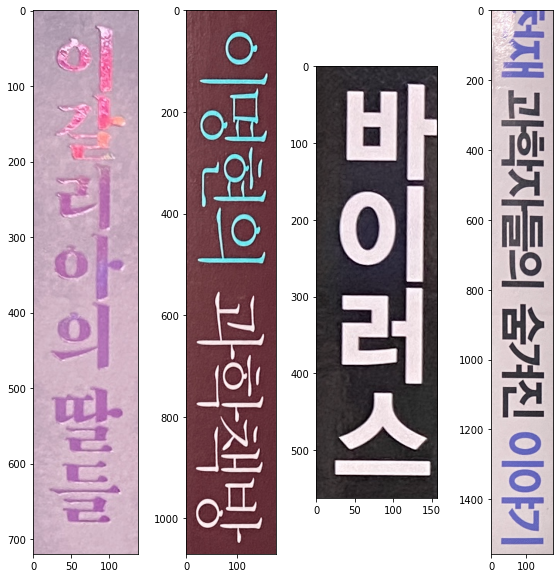

In [ ]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(1,4,1)
ax2 = fig.add_subplot(1,4,2)
ax3 = fig.add_subplot(1,4,3)
ax4 = fig.add_subplot(1,4,4)
ax1.imshow(stage2_2_stage3[0])
ax2.imshow(stage2_2_stage3[1])
ax3.imshow(stage2_2_stage3[2])
ax4.imshow(stage2_2_stage3[3])
fig.show()


In [ ]:
def show_bbox(file_path, bbox_list):
    img = cv2.imread(file_path) 
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    green = (0,255,0)
    red = (255,0,0)

    img_show = cv2.rectangle(img_rgb, (int(bbox_list[0]), int(bbox_list[1])), (int(bbox_list[2]), int(bbox_list[3])), color = green, thickness = 2) # label_bbox 표시 
    
    plt.figure(figsize=(10,10))
    plt.imshow(img_show)
    plt.show()

### stage3. title OCR

In [ ]:
def detect_text(img_bytes):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    # with io.open(path, 'rb') as image_file:
    #     content = image_file.read()
        
    image = vision.Image(content=img_bytes) # byte로 받아서 바로 실행

    response = client.text_detection(image=image)
    texts = response.text_annotations
    
    # 제목을 한 문장으로 추출할 수 있도록 코드 수정 (공백 제거)
    result = ''
    for idx, text in enumerate(texts):
        if idx > 0: result += text.description 
    return result

    # if response.error.message:
    #     raise Exception(
    #         '{}\nFor more info on error messages, check: '
    #         'https://cloud.google.com/apis/design/errors'.format(
    #             response.error.message))

In [ ]:
def img2gray(image_array):
    img_gray = cv2.cvtColor(image_array, cv2.COLOR_RGB2GRAY)
    add_dst = cv2.add(img_gray, 100) # 밝기 조절
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4, 4)) # 대비 조절
    gray_cont_dst = clahe.apply(add_dst)

    img_bytes = cv2.imencode('.jpg', gray_cont_dst)[1].tobytes()

    return img_bytes

In [ ]:
stage3_result = []
for img_array in stage2_2_stage3:
    stage3_input = img2gray(img_array)
    stage3_result.append(detect_text(stage3_input))

In [ ]:
stage3_result

['리아의딸도', '이명현의과학책방', '바이러스', '처재과학자들의숨겨진이야기']

### stage1 to stage3 결합

In [ ]:

start = time.time()

# stage1. bookspine detection

stage1_model = torch.hub.load('ultralytics/yolov5', 'custom', path='/content/drive/MyDrive/Aiffel_Hakathon/3rd_hackathon/model_test_ver2/stage1/stage1_weights/stage1_m_epochs_50.pt')

stage1_model.conf = 0.3

img_path = '/content/drive/MyDrive/Aiffel_Hakathon/3rd_hackathon/model_combine/stage1_test_image/test6.jpg'
img = cv2.imread(img_path)[..., ::-1]

results = stage1_model(img)
stage1_df = results.pandas().xyxy[0]

# bbox 선택
# ex. 0~3번 index의 bbox 선택을 가정
stage1_bbox_list = []

for i in range(4):
    stage1_bbox_list.append(stage1_df.iloc[i][:4].tolist())

# stage1에서 stage2로 보낼 이미지 크롭
stage1_to_stage2 = []

for stage1_bbox in stage1_bbox_list:
    spine_crop = img[int(stage1_bbox[1]):int(stage1_bbox[3]), int(stage1_bbox[0]):int(stage1_bbox[2])].copy()
    stage1_to_stage2.append(spine_crop)

# stage2. booktitle detection

stage2_model = torch.hub.load('ultralytics/yolov5', 'custom', path='/content/drive/MyDrive/Aiffel_Hakathon/3rd_hackathon/stage2_iou_test/stage2_final.pt')

stage2_model.max_det = 1
stage2_model.conf = 0.3
stage2_result = []

for i, img in enumerate(stage1_to_stage2):
    results = stage2_model(img)
    make_list = results.pandas().xyxy[0].iloc[0].tolist()
    stage2_result.append(make_list)

# stage2의 bbox를 리스트로 출력

stage2_bbox_list = []
for i, coord in enumerate(stage2_result):
    stage2_bbox_list.append(stage2_result[i][:4])

# stage2에서 stage3로 보낼 이미지 크롭
stage2_2_stage3 = []
stage2_img = ''
for i, stage1_crop in enumerate(stage1_to_stage2):
    stage2_img_crop = stage1_crop[int(stage2_bbox_list[i][1]):int(stage2_bbox_list[i][3]), int(stage2_bbox_list[i][0]):int(stage2_bbox_list[i][2])].copy()
    stage2_2_stage3.append(stage2_img_crop)

# stage3. Title OCR
stage3_result = []
for img_array in stage2_2_stage3:
    stage3_input = img2gray(img_array)
    stage3_result.append(detect_text(stage3_input))

print(stage3_result)

print(time.time() - start)

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-3-1 torch 1.10.0+cu111 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model Summary: 290 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 
Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-3-1 torch 1.10.0+cu111 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model Summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


['말들', '이명현의과학책방', '바이러스', '처재과학자들의숨겨진이야기']
5.021038770675659


### stage1. bookspine detection 의문점??
1. 문득 든 생각인데... 어차피 bbox를 선택할 거면 굳이 stage1, stage2로 나눌 필요가 없지 않을까? 바로 stage2만 돌려서 제목 bbox만 선택해서 ocr 돌려도 될 거 같은데...?   
2. bbox를 선택하기 전에 수정하는 기능이 있으면 좋을듯??

In [ ]:
start = time.time()

# 모델 설정(s모델).
model = torch.hub.load('ultralytics/yolov5', 'custom', path='/content/drive/MyDrive/Aiffel_Hakathon/3rd_hackathon/stage2_iou_test/stage2_final.pt')

model.conf = 0.3

img_path = '/content/drive/MyDrive/Aiffel_Hakathon/3rd_hackathon/model_combine/stage1_test_image/test6.jpg'
img = cv2.imread(img_path)[..., ::-1] # BGR to RGB 

results = model(img) # 모델의 결과값 저장
df = results.pandas().xyxy[0] # 결과값을 pandas dataframe으로 저장

print(str(time.time() - start) +' sec')   

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-3-1 torch 1.10.0+cu111 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model Summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


5.670921802520752 sec


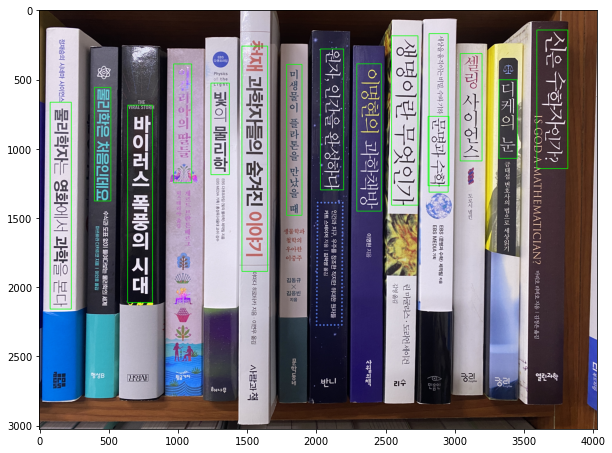

In [ ]:
img_file_path = '/content/drive/MyDrive/Aiffel_Hakathon/3rd_hackathon/model_combine/stage1_test_image/test6.jpg'
img = cv2.imread(img_file_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
green = (0, 255, 0)

for i in range(df.shape[0]):
    bbox = df.iloc[i][:4].tolist()
    img_show = cv2.rectangle(img_rgb, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), color = green, thickness = 4) # label_bbox 표시 
plt.figure(figsize=(10,10))
plt.imshow(img_rgb)
plt.show()

In [ ]:
df

,xmin,ymin,xmax,ymax,confidence,class,name
0,2296.405762,388.828430,2473.508301,1451.376831,0.868493,0,title
1,80.399734,665.501892,233.805038,2158.913086,0.830101,0,title
2,640.268799,686.697144,820.470154,2111.665283,0.826708,0,title
3,400.803894,558.940308,519.155823,1378.657227,0.816001,0,title
4,2033.126099,281.269104,2201.024414,1298.466797,0.815827,0,title
5,1789.067017,392.368774,1900.406372,1481.220581,0.792344,0,title
6,3597.733154,144.742477,3821.723145,1144.565430,0.791043,0,title
7,3043.806152,314.219177,3201.579834,1089.258423,0.784664,0,title
8,2547.039551,186.661575,2738.612549,1408.804810,0.763504,0,title
9,1242.291504,527.559570,1375.209351,1188.187622,0.702515,0,title
